# Isolation Forest Test
This notebook shows how to run Isolation Forest test.

## Import libraries

In [1]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Importing IsolationForest module
from sklearn.ensemble import IsolationForest

#Importing Line2D for marking legend in graph
from matplotlib.lines import Line2D

#Just to filter out warnings- Well I hate warnings popping on the screen 
import warnings
warnings.filterwarnings("ignore")

#We set the seed for random, so we generate same results whenever we run
np.random.seed(0)

### Generate outliers dataset

In [2]:
#Now we will generate datasets 

#Generating a normally distributed data set for training
X = 0.3 * np.random.randn(100, 2)
X_train_normal = np.r_[X + 2, X - 2]

#Generating outliers for training
X_train_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

#Generating a normally distributed dataset for testing
X = 0.3 * np.random.randn(20, 2)
X_test_normal = np.r_[X + 2, X - 2]

#Generating outliers for testing
X_test_outliers = np.random.uniform(low=-4, high=4, size=(10, 2))

### Visulize data

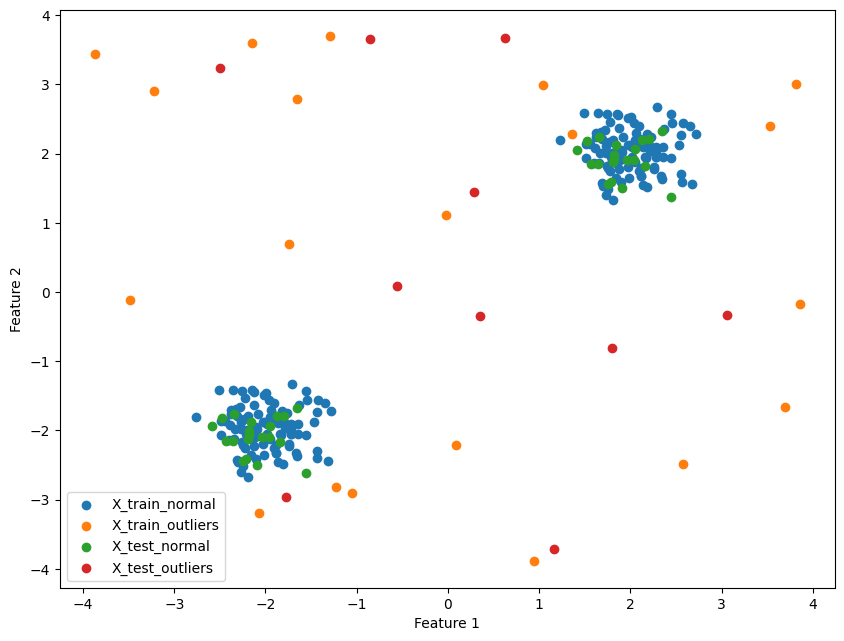

In [3]:

#Plotting and visualising the data points
plt.figure(figsize=(10,7.5))
plt.scatter(X_train_normal[:,0],X_train_normal[:,1],label='X_train_normal')
plt.scatter(X_train_outliers[:,0],X_train_outliers[:,1],label='X_train_outliers')
plt.scatter(X_test_normal[:,0],X_test_normal[:,1],label='X_test_normal')
plt.scatter(X_test_outliers[:,0],X_test_outliers[:,1],label='X_test_outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

### Concate Normal and outliers data

In [4]:
#Now we will append the normal points and outliers- train and test separately
X_train=np.append(X_train_normal,X_train_outliers,axis=0)
X_test=np.append(X_test_normal,X_test_outliers,axis=0)



### Training with isolation forest algorithm


In [5]:
#Training with isolation forest algorithm
clf = IsolationForest(random_state=0, contamination=0.1)
clf.fit(X_train)

#Now we predict the anomaly state for data
y_train=clf.predict(X_train)
y_test=clf.predict(X_test)  

### Prediction output

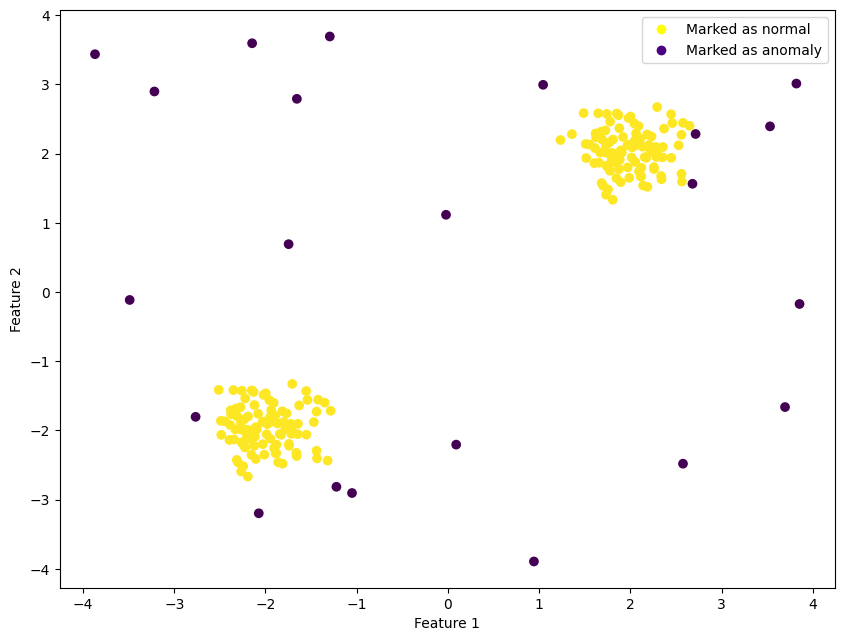

In [6]:
#Now we will plot and visualize how good our algorithm works for training data
#y_train(the state) will mark the colors accordingly
plt.figure(figsize=(10,7.5))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

 
#This is to set the legend appropriately
legend_elements = [Line2D([], [], marker='o', color='yellow', label='Marked as normal',linestyle='None'),
                   Line2D([], [], marker='o', color='indigo', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)

In [7]:
import validmind as vm


vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  project = "clhsvn7va0000kgrl0nwybdff"
)

2023-06-16 16:29:49,738 - INFO - api_client - Connected to ValidMind. Project: Customer Churn Model dev - Initial Validation (clhsvn7va0000kgrl0nwybdff)


In [8]:
vm_data = pd.DataFrame(X_train)
vm_dataset = vm.init_dataset(
    dataset=vm_data,
    type="generic",
)
type(vm_dataset.raw_dataset)


2023-06-16 16:29:49,750 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-16 16:29:49,751 - INFO - dataset - Inferring dataset types...


pandas.core.frame.DataFrame

In [9]:
from dataclasses import dataclass
from validmind.vm_models import ThresholdTest
from sklearn import metrics

from validmind.vm_models import Figure, ThresholdTest
#Importing IsolationForest module
from sklearn.ensemble import IsolationForest
#Importing Line2D for marking legend in graph
from matplotlib.lines import Line2D
import seaborn as sns

@dataclass
class MyIsolationForest(ThresholdTest):
    """
    Isolation Forest
    """

    name = "isolation_forest"
    default_params = {"random_state": 0, "contamination" : 0.1}    
    required_context = ["dataset"]

    def run(self):
        dataset = self.dataset.df
        #Training with isolation forest algorithm
        clf = IsolationForest(random_state=self.params["random_state"], contamination=self.params["contamination"])
        clf.fit(dataset)
        y_pred = clf.predict(dataset)

        ## figure
        plt.figure(figsize=(10,7.5))
        # plt.scatter(dataset[0].values, dataset[1].values, c=pd.DataFrame(y_pred))
        sns.scatterplot(data=dataset, x=dataset[0].values, y=dataset[1].values, hue=y_pred, palette="bright")

        return self.cache_results([],passed=True)


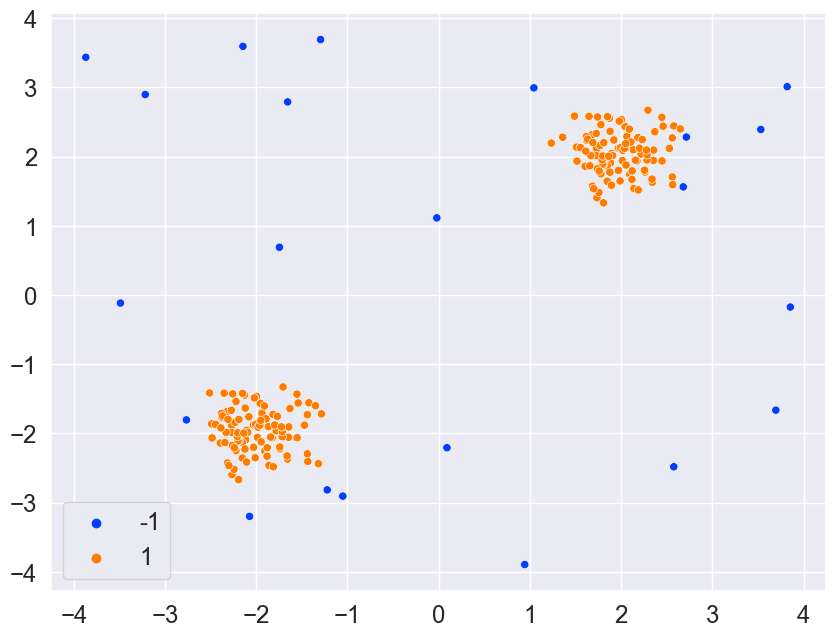

In [10]:
from validmind.vm_models.test_context import TestContext
test_context = TestContext(dataset=vm_dataset)
ws_diagnostic = MyIsolationForest(test_context)
ws_diagnostic.run()
ws_diagnostic.result.show()